In [69]:
# Importing libraries necessary for EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
#importing models from scikit learn 
from sklearn.svm import SVC #Support Vector Machine
from xgboost import XGBClassifier #XGBoost
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Importing hypertuning libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')

## 1. Data Loading 

In [70]:
# Using pandas read_csv() function to read the csv file and the head function to take a look at the first 5 rows of the dataset
df = pd.read_csv(r"C:\Users\User\Desktop\DiabetesML-Supervised-Classfication-\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [71]:
df.shape

(768, 9)

* The dataset is composed of **9 columns and 768 rows**.

The next step is to take a look at the validity of the dataset. I will check for null values and impute using mean or median as per the distribution of the data for any null values.

In [72]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* There are no null values in the dataset. 

In [73]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

The target variable being predicted is the **Outcome** column (also known as **Y or dependent variable**). 

The values are imbalanced which is common in classification problems that deal with events that are rare, some examples of this: 

* Fraud Detection
* Medical Diagnosis
* Natural disaster prediction

This is an issue as models tend to favor the majority class as it minimizes overall error. This results in poor generalization for the minority class. Rare but important cases are missed by the model because it wants to keep accuracy score high and predictiing wrong would cause that score to fall. 


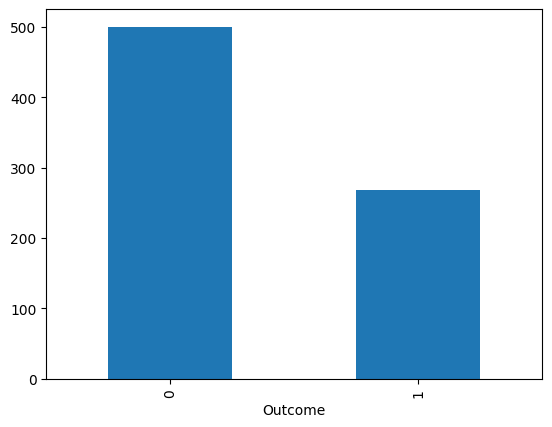

In [74]:
df['Outcome'].value_counts().plot(kind = 'bar')
plt.show()

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* The data is composed of all numerical values with the rows being in either an `int64` or `float64 `data type.
I will take a look at some summary statitics for the data to see if there are any irregularities.

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


* One thing that jumps out at me is the standard deviation valie for the `Insulin` column. The average value is **79.80 while the deviation is 115.2**. 
* The `skin thickness` is another variable where the deviation is a little too close to the mean.

* I also see some records with 0 values when there shouldn't be such as **BMI, Insulin, Glucose and Blood Pressure**.


The next step of the EDA process would be to plot boxplots to look at the Outliars in the dataset as well as invetigate the value distribution of each of our inependent variables.



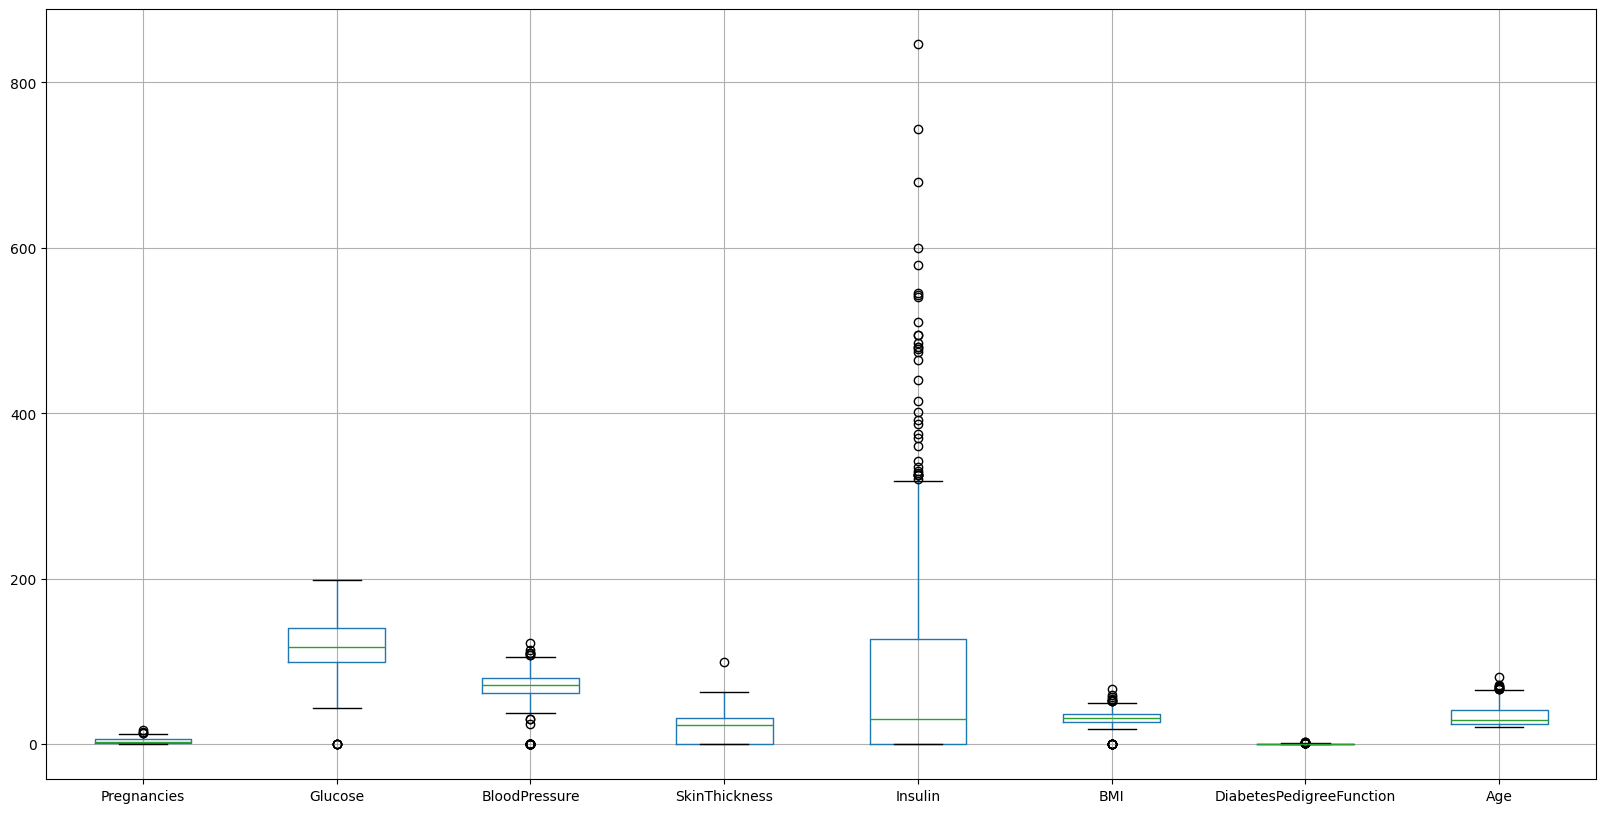

In [77]:
df.iloc[:, : (df.shape[1]-1)].boxplot(figsize=(20,10)) # Taking out the Dependent variable column 'Outcomes'
plt.show()

* Our initial hunch about the **Insulin** column deviation was correct as we can observe many outliers as per the boxplot above. Surprisingly there was alot of outliars observed for other variables as well.
* There were also many independent variables with a good amount of outliars observed such as: **Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Age**.
* There were also many zero values for independent variables where there shouldn't be such as: **Insulin, BMI, Blood Pressure**.

I will then recheck for outliers and construct a function to remove any of the remaining outliers prior to continuing with the Data precprocessing stage.


In [78]:
for col in df.columns[:-1]:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
df.isnull().sum()
# The values of outliers for each column in the dataset can be seen in the value counts below

Pregnancies                  4
Glucose                      5
BloodPressure               45
SkinThickness                1
Insulin                     34
BMI                         19
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64

In [79]:
df.fillna(df.median(), inplace=True)
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

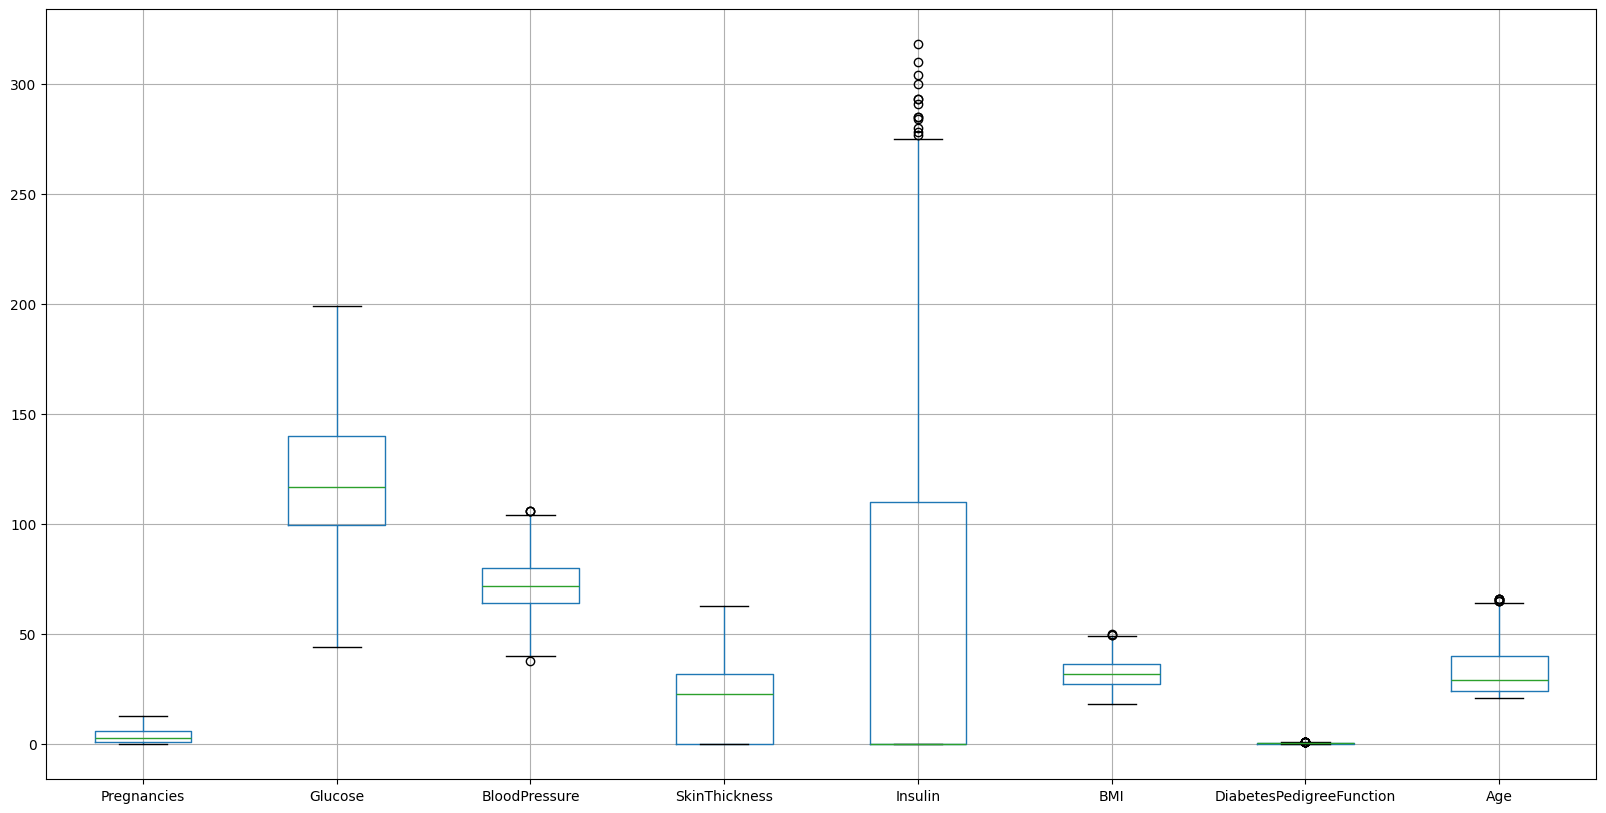

In [80]:
df.iloc[:, : (df.shape[1]-1)].boxplot(figsize=(20,10)) # Taking out the Dependent variable column 'Outcomes'
plt.show()

* As observed from the cells above the amount of outliers in the dataset has decreased significantly. 
* **Median imputation** was selected as its is a more centrail measure meaning it is likely to affect the mean.

The heatmap showing the correlation between the cleaned models is to be plotted next: 


<Axes: >

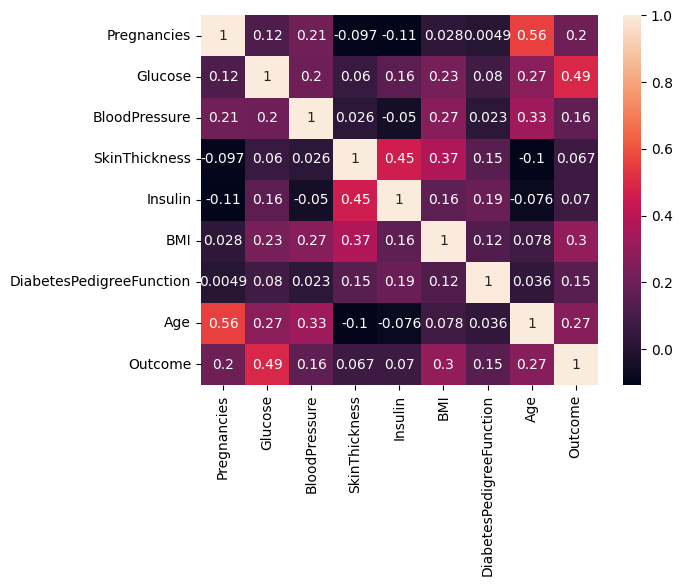

In [81]:
sns.heatmap(df.corr(), annot = True)

* The independent factor with the greatest correlation coefficient with the target variable is glucose with Pearson coefficient factor of 0.49 (Weak to Moderate Correlation).

Up next will be the balancing out the Target variable (Outcome). There are many ways to do this depending on the size of the dataset and the amount of the major and minor outcome labels. In our case it 500 to 276 so not too bad. 

There are two possible resampling tehcniques each with their own pros and cons. 
1. Oversampling the minority class 
2. Undersampling the Majority class (the dataset is not large to enough at 768 records to do this and still get a proper model built).

The method that is going to be applied will be **"Oversampling the minority class"**; more specifically **SMOTE (Synthetic Minority Oversampling Technique)**: Which is a method of oversampling that generates synthetic samples by interpolating between existing minority class samples as opposed to **Random Oversampling** which duplilcates examples from the minority class to balance out the data.

### Seperating Features and Target Variable

In [82]:
#Seperating features and target variable
X = df.drop('Outcome', axis = 1)
y = df['Outcome']


In [83]:
# Applying SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE 
# Initiaslizing SMOTE
smote = SMOTE(random_state = 42)
# Applying SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X,y)


#Confirming the dataset was resampled
print(pd.Series(y_resampled).value_counts())
print(X_resampled.shape)

Outcome
1    500
0    500
Name: count, dtype: int64
(1000, 8)


Scaling the data(Standardization)

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std = scaler.fit_transform(X_resampled)
X_resampled = std
print(X_resampled.shape)

(1000, 8)


## 3. Model Selection 

The following models will be compared to see which predicts the test data with the highest accuracy. 
1. Random Forrest Classifier 
2. SVM (Support Vector Machine) Algorithms 
3. XGBoostClassifier Model

#1. Random Forest Classifier

The average accuracy of random forest classifier is 0.8206


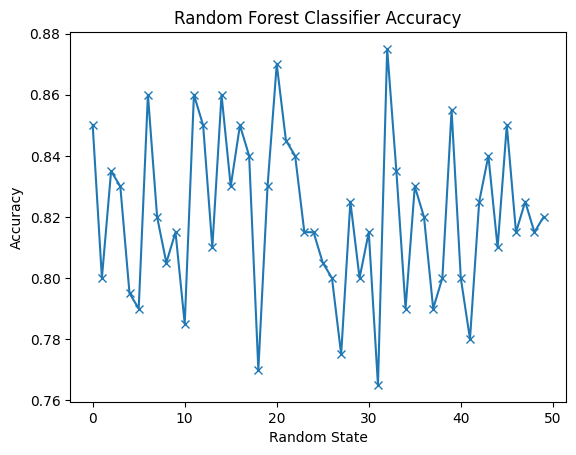

In [85]:
n = 50 
random_state = []
forest_accuracy = []
for i in range(n): 
    random_state.append(i)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = i, stratify = y_resampled)
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    forest_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of random forest classifier is {np.mean(forest_accuracy)}")

plt.plot(random_state, forest_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy')
plt.show()



#2. Support Vector Classifier

The average accuracy of Support Vector Classifier is 0.8016999999999999


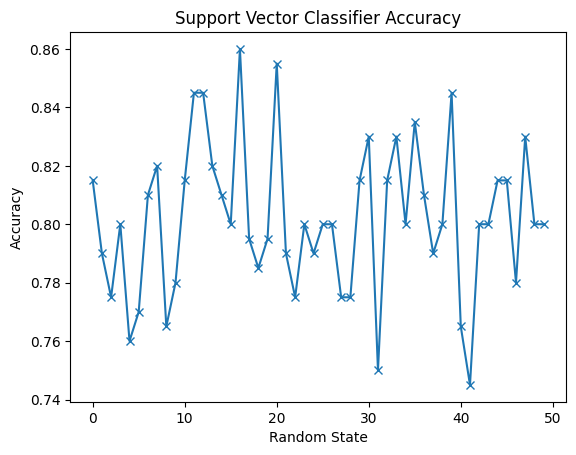

In [86]:
n = 50 
random_state = []
svm_accuracy = []
for i in range(n): 
    random_state.append(i)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = i, stratify = y_resampled)
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    svm_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of Support Vector Classifier is {np.mean(svm_accuracy)}")


plt.plot(random_state, svm_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Support Vector Classifier Accuracy')
plt.show()

3. XGB Classifier

The average accuracy of XGB classifier is 0.8061


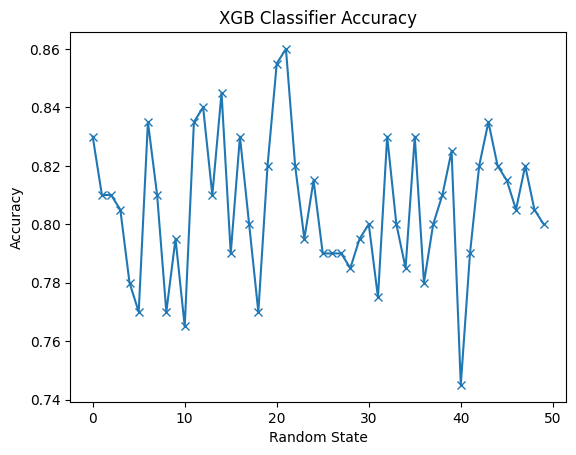

In [87]:
n = 50 
random_state = []
xgb_accuracy = []
for i in range(n): 
    random_state.append(i)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = i, stratify = y_resampled)
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of XGB classifier is {np.mean(xgb_accuracy)}")

plt.plot(random_state, xgb_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('XGB Classifier Accuracy')
plt.show()

* A brief summary of the models and the mean accuracy noted. 

| Model                          | Mean Accuracy  | 
|--------------------------------|----------|
| #1. Random Forest  | 82.5% | 
| #2. SVC   |80.2%  | 
| #3.XGB    |80.6%|

# Hyperparameter Optimization
The next step would be hyperparameter optimization with the model with the highest mean accuracy; in this case Random Forest Classifier (RFC). 
This is done below: 


In [90]:
# Tuning the hyperparameters of the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [20, 30, 40, 50, 80, None],
    'criterion': ['gini', 'entropy'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 19, stratify = y_resampled)
#create the the svm model
model = RandomForestClassifier()

#create a gridsearchCV of the model 
rfc = GridSearchCV(model, param_grid= param_grid, refit = True, verbose = 2, cv = 5, n_jobs= -1, scoring = 'accuracy')

#fit the model 
rfc.fit(X_train, y_train)
#use the ebst model for predictions
y_pred = rfc.predict(X_test)
#evaluate the model 
print("Final Accuracy score of RFC", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits
Final Accuracy score of RFC 0.84
